Цель: Использун созданный вами датасет из предыдущей лекции, выполните дообучение существующей модели для упучшения ее производительности на новой задаче.

Описание задании:

1.Выбор модели для дообученик:

Обоснуйте свой выбор, указан, почему выбранная модель подходит для дообучения на вашем датасете.

2.Подготовка данных:

Проверьте качество и разнообразие собранного пами датасета.
Выполните необходимую предобреботку данных (удаление шума, токенизация, нормализации и т.д.). Раздипите датасет на тренировочную, вапидационную и тестовую выборки.

3.Дообучение модели:

Допопнительные задания:

Настройте гиперпараметры/параметры модели, учитыая специфику вашего датасета.

Проведите процесс дообучения модели на собранных данных.
Попробуйте дообучить несколько различных моделей и сравнить их резупьтаты.

4.Оценка модели:

Проведите эксперименты с различными гиперпараметрами, чтобы понить, как они климат на качество добученной модели.

Оцените производительность модели на вапидационной и тестовой выборках.

Сравните результаты до и после дообучения.

Примените методы дли предотвращения переобучения (регуляризация, ранния остановка и т.д.) и сравните результаты.

Опишите, какие изменения в модели произошали, какие задачи она стала решать лучше или хуже.

# Часть 1(финальный забег)

Задача для нашего датасета: определить, насколько нужно и срочно посещение психиатра в конкретном случае по истории человека

Выберем модели, которую будем дообучать.

Возьму Tini_llama дообученную на корпусе русских слов(https://huggingface.co/AlexWortega/tini_llama_full?library=transformers). Пробовал и другие подели, но с ними все работало отвратительн(либо не хватало памяти)

In [35]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("AlexWortega/tini_llama_full")
model = AutoModelForCausalLM.from_pretrained("AlexWortega/tini_llama_full")

# Часть 1(обработаем данные)

Мы возьмем за эталон те данные, которые были получены в предыдущем задании(во многом они были максимально правдоподобны и верны вплоть до погрешности. Убедился в этом, когда начал вручную размечать данные. Слишком много попадений)

Обработаем их, достанем только проценты - то, насколько необходим поход к врачу(это будет играть роль когда мы будем смотреть метрики моделей)

In [3]:
import pandas as pd
import re

df = pd.read_csv('datasett.csv')
#df['percentage'] = df['ans'].apply(lambda x: re.findall(r'(\d+)(?=%)', x)[-1])
df.drop(columns=['Unnamed: 0', 'attrs'], inplace=True)
df

,request,ans
0,Мой сын стал избегать общения с друзьями и отк...,Возможные психологические расстройства:\n\nСоц...
1,"Моя дочь часто смеется и радуется, любит играт...",Возможные психологические расстройства:\n\nЭйф...
2,"Мой ребенок стал очень раздражительным, часто ...",Возможные психологические расстройства:\n\nДеп...
3,"Моя дочь говорит, что слышит голоса, которые з...",Возможные психологические расстройства:\n\nПар...
4,Мой сын часто смеется и весело проводит время ...,Возможные психологические расстройства:\n\n О...
...,...,...
95,Моя дочь стала бояться выступать перед классом...,Возможные психологические расстройства:\n\nСоц...
96,"Мой сын перестал радоваться жизни, выглядит по...",Возможные психологические расстройства:\n\nДеп...
97,"Моя дочь стала одержима своей фигурой, сидит н...",Возможные психологические расстройства:\n\nЭ E...
98,"Мой сын стал замкнутым, не хочет общаться с се...",Возможные психологические расстройства:\n\nСоц...


Протестируем модель:

In [36]:
def generate_recommendation(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

    outputs = model.generate(
        **inputs,
        max_length=610,
        num_beams=5,
        early_stopping=True
    )

    recommendation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return recommendation
input_text = f'''

 {df["request"][80]}
Мне нужно идти к психологу? напиши одно число 
'''

print(generate_recommendation(input_text))



 Мой сын стал избегать еды, говорит, что боится отравиться, и ест только определенные продукты."
Мне нужно идти к психологу? напиши одно число 
  1. 0
  2. 1
  3. 2
  4. 3
  5. 4
  6. 5
  7. 6
  8. 7
  9. 8
  10. 9
  11. 10
  12. 11
  13. 12
  14. 13
  15. 


Разделим датасет на тестовую и тренировочную выборки

In [4]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


Эти самые проценты будут эталоном для модельки

Попробуем обозначить что мы хотим и достать проценты сырой gemma2 с минимальным промптом для сравнения впоследствие. 

Посмотрим, как она будет      у нас работать

In [5]:
from transformers import AutoTokenizer

tokenizer.pad_token = tokenizer.eos_token
def tokenize_and_prepare(examples):
    inputs = tokenizer(examples['request'], truncation=True, padding='max_length', max_length=512)
    targets = tokenizer(examples['ans'], truncation=True, padding='max_length', max_length=512)
    inputs['labels'] = targets['input_ids']
    return inputs
train_dataset = train_dataset.map(tokenize_and_prepare, batched=True)
test_dataset = test_dataset.map(tokenize_and_prepare, batched=True)
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

# Часть 3(учим, но ничего не учится)

Напишем цикл обучения модели

In [6]:
from datasets import DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [7]:
from transformers import Trainer, TrainingArguments
from transformers import TrainerCallback
class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.logs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.logs.append(logs)

logging_callback = LoggingCallback()

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_steps=10,
    learning_rate=0.1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[logging_callback],
)

trainer.train()


c:\Users\Ivan\PycharmProjects\pythonProject7\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 2.058337688446045, 'eval_runtime': 225.2893, 'eval_samples_per_second': 0.089, 'eval_steps_per_second': 0.004, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 2.057295322418213, 'eval_runtime': 224.6893, 'eval_samples_per_second': 0.089, 'eval_steps_per_second': 0.004, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 2.056861400604248, 'eval_runtime': 224.7762, 'eval_samples_per_second': 0.089, 'eval_steps_per_second': 0.004, 'epoch': 3.0}
{'train_runtime': 9902.4607, 'train_samples_per_second': 0.024, 'train_steps_per_second': 0.001, 'train_loss': 2.2522449493408203, 'epoch': 3.0}


TrainOutput(global_step=9, training_loss=2.2522449493408203, metrics={'train_runtime': 9902.4607, 'train_samples_per_second': 0.024, 'train_steps_per_second': 0.001, 'total_flos': 805390421852160.0, 'train_loss': 2.2522449493408203, 'epoch': 3.0})

Оценим качество модели и сохраним ее. Нарисуем графики

In [10]:
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

trainer.evaluate()

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 2.056861400604248,
 'eval_runtime': 224.659,
 'eval_samples_per_second': 0.089,
 'eval_steps_per_second': 0.004,
 'epoch': 3.0}

Нарисуем графики

In [13]:
logging_callback.logs

[{'eval_loss': 2.058337688446045,
  'eval_runtime': 225.2893,
  'eval_samples_per_second': 0.089,
  'eval_steps_per_second': 0.004,
  'epoch': 1.0},
 {'eval_loss': 2.057295322418213,
  'eval_runtime': 224.6893,
  'eval_samples_per_second': 0.089,
  'eval_steps_per_second': 0.004,
  'epoch': 2.0},
 {'eval_loss': 2.056861400604248,
  'eval_runtime': 224.7762,
  'eval_samples_per_second': 0.089,
  'eval_steps_per_second': 0.004,
  'epoch': 3.0},
 {'train_runtime': 9902.4607,
  'train_samples_per_second': 0.024,
  'train_steps_per_second': 0.001,
  'total_flos': 805390421852160.0,
  'train_loss': 2.2522449493408203,
  'epoch': 3.0},
 {'eval_loss': 2.056861400604248,
  'eval_runtime': 224.8969,
  'eval_samples_per_second': 0.089,
  'eval_steps_per_second': 0.004,
  'epoch': 3.0},
 {'eval_loss': 2.056861400604248,
  'eval_runtime': 224.659,
  'eval_samples_per_second': 0.089,
  'eval_steps_per_second': 0.004,
  'epoch': 3.0}]

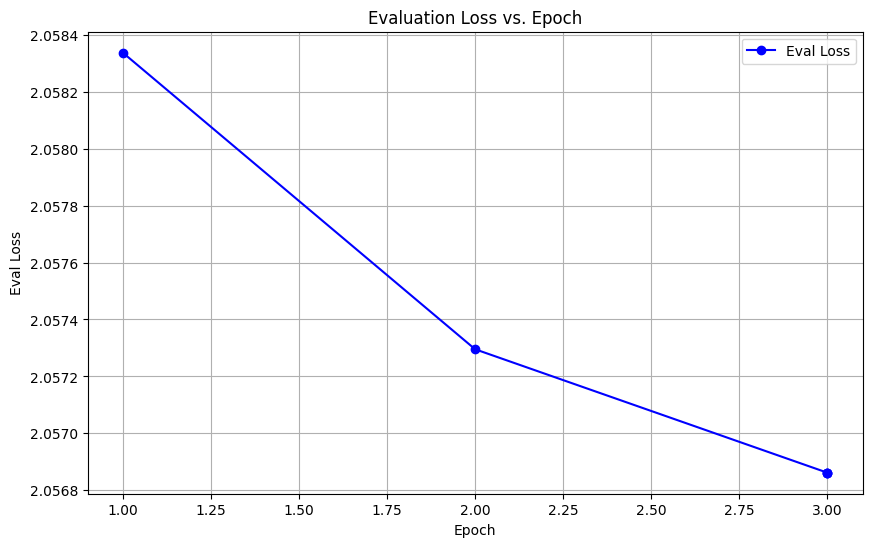

In [14]:

import matplotlib.pyplot as plt
import pandas as pd

logs_df = pd.DataFrame(logging_callback.logs)



epochs = logs_df['epoch']
eval_loss = logs_df['eval_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_loss, marker='o', linestyle='-', color='b', label='Eval Loss')

plt.title('Evaluation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.legend()
plt.grid(True)
plt.show()



# Часть 4(что мы наделали...)

Проверим качество дообученной модели на тестовом датасете

In [20]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("./model")
model = AutoModelForCausalLM.from_pretrained("./model")

def generate_recommendation(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

    outputs = model.generate(
        **inputs,
        max_length=610,
        num_beams=5,
        early_stopping=True
    )

    recommendation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return recommendation



Протестируем модель

In [34]:
tokenizer = AutoTokenizer.from_pretrained("./model")
model = AutoModelForCausalLM.from_pretrained("./model")
input_text = f'''

 {df["request"][80]}
Мне нужно идти к психологу? напиши одно число 
'''

print(generate_recommendation(input_text))



 Мой сын стал избегать еды, говорит, что боится отравиться, и ест только определенные продукты."
Мне нужно идти к психологу? напиши одно число 
  1. 0
  2. 1
  3. 2
  4. 3
  5. 4
  6. 5
  7. 6
  8. 7
  9. 8
  10. 9
  11. 10
  12. 11
  13. 12
  14. 13
  15. 


Разница до и после обучения не существенная и не стоит того. Допускаю, что где-то что-то было сделано не так